In [94]:
import pandas as pd
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf


# RNN uses previous 50 close prices to predict the average over the next 5 close prices.
previous_timesteps = 50

def import_csv(filename):
    df = pd.read_csv(filename)
    selected_columns = ['Open time', 'Close']
    df = df[selected_columns]
    return df

def generate_rolling_averages(df):
    df['5_unit_avg'] = df['Close'].rolling(window=5).mean()
    df['20_unit_avg'] = df['Close'].rolling(window=20).mean()
    df['60_unit_avg'] = df['Close'].rolling(window=60).mean()
    df['10080_unit_avg'] = df['Close'].rolling(window=10080).mean()
    return df

def generate_numpy_array(df, timefrom, timeto):

    # We take the df provided and give a numpy array with shape (dflength, 50, 6)
    # Df Length is the length of the dataframe, and the 50 is the 50 entries before
    # 1st column in the df is the time and the next 5 are the close + rolling averages.

    # Find index of time from and time to
    timefrom = pd.to_datetime(timefrom)
    timeto = pd.to_datetime(timeto)
    # convert to unix time milliseconds
    timefrom = timefrom.timestamp() * 1000
    timeto = timeto.timestamp() * 1000

    timefrom_index = df[df['Open time'] == timefrom].index[0]
    timeto_index = df[df['Open time'] == timeto].index[0]

    print (timefrom)
    print (timeto)

    # Assuming df is your DataFrame and it has 6 columns
    dfLength = len(df[timefrom_index:timeto_index])

    # Initialize the 3D array
    array_3d = np.zeros((dfLength, 50, 6))

    # Fill the 3D array
    for i in range(timefrom_index, timeto_index):
        # Determine the start index for slicing the DataFrame, ensuring it's not negative
        start_idx = max(i - 49, 0)
        # Slice the DataFrame to get up to 50 rows ending with the current row
        temp_df = df.iloc[start_idx:i+1]
        #print(temp_df)
        # If there are fewer than 50 rows, pad the beginning with zeros
        if len(temp_df) < 50:
            padding = np.zeros((50 - len(temp_df), 6))
            temp_array = np.vstack((padding, temp_df.to_numpy()))
        else:
            temp_array = temp_df.to_numpy()
            # Assign this 2D array to the corresponding "page" in the 3D array
            array_3d[i-timefrom_index, :, :] = temp_array
    return array_3d

def remove_time(numpy_array):
    return numpy_array[:, :, 1:]

def normalise_numpy_array(array_3d, fulldataframe):
    for i in range(5):
        min_val = fulldataframe.iloc[:, i + 1].min()
        max_val = fulldataframe.iloc[:, i + 1].max()
        array_3d[:, :, i] = (array_3d[:, :, i] - min_val) / (max_val - min_val)
    return array_3d

def fit_to_model(array_2d, model):
    # 2D array is the array of the last 50 close prices
    # We need to fit this to the model and get the prediction

    array_2d = array_2d.reshape(-1, previous_timesteps, 5)
    # print(array_2d)
    # print(array_2d.shape)
    prediction = model.predict(array_2d)
    return prediction

def check_prediction(current, prediction, position):
    # Get percentage difference between current and prediction
    percentage_difference = (prediction - current) / current

    # If percentage difference is greater than 0.002, return buy
    # Else return close
    if percentage_difference > 0.0001:
        if position == 'buy' or position == 'hold':
            return 'hold'
        else:
            return 'buy'
    elif percentage_difference < -0.0001:
        if position == 'buy' or position == 'hold':
            return 'close'
        else:
            return 'nothing'
    else:
        if position == 'buy'  or position == 'hold':
            return 'hold'
        return 'nothing'
    
def check_ROI(array_3d):
    currententry = 0
    currentROI = 0
    position = 'close'
    for i in range(array_3d.shape[0]):
        prediction = check_prediction(array_3d[i, 0, 0], array_3d[i, 0, 5], position)
        if prediction == 'buy':
            position = 'buy'
            currententry = array_3d[i, 0, 0]
        elif prediction == 'close':
            if position == 'buy':
                position = 'close'
                currentROI += (array_3d[i, 0, 0] - currententry) / currententry + currentROI * (array_3d[i, 0, 0] - currententry) / currententry
    return currentROI
     

In [85]:
   
    
# Import BTCUSDT.h5 current folder.
# print tensorflow version
print(tf.__version__)
#model = tf.keras.models.load_model('BTCUSDT.h5')
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,losses

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

x_length = 5
seq_length = 50

model = models.Sequential()
model.add(tf.keras.Input(shape=(seq_length, x_length)))  # Specify the input shape here
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(50))
model.add(layers.Dense(1))  # Output layer with future_steps units

model.compile(optimizer='adam',
              loss=losses.Huber(),
              metrics=[losses.MeanAbsoluteError()])

# now load the weights from BTCUSD.keras
model.load_weights('BTCUSDT.keras')

#Import the CSV file
df = import_csv('BTCUSDT.csv')

# Generate rolling averages
df = generate_rolling_averages(df)

# Generate numpy array
array_3d = generate_numpy_array(df, '2021-01-01 00:00:00', '2021-01-02 00:00:00')

#print (array_3d)
#Remove time from numpy array
array_3dn = remove_time(array_3d)

# # Normalise the numpy array
array_3dn = normalise_numpy_array(array_3dn, df)

# # starting_cost = 100
prediction_array = np.pad(array_3dn, ((0, 0), (0, 0), (0, 1)), mode='constant')
# #Fit the model for our chosen sample.
for i in range(array_3dn.shape[0]):
    # the prediction
    prediction = fit_to_model(array_3dn[i,:,:], model)
    prediction_array[i, :, 5] = prediction[0]

2.16.2


/home/isaac/Project-TW/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1609459200000.0
1609545600000.0
[[[1.60945626e+12 2.90566700e+04 2.90501980e+04 2.90683890e+04
   2.90830960e+04 2.67014019e+04]
  [1.60945632e+12 2.90957500e+04 2.90629620e+04 2.90672285e+04
   2.90843143e+04 2.67019580e+04]
  [1.60945638e+12 2.90722900e+04 2.90672540e+04 2.90644925e+04
   2.90847385e+04 2.67025114e+04]
  ...
  [1.60945908e+12 2.89236700e+04 2.89662740e+04 2.89398980e+04
   2.89930127e+04 2.67264395e+04]
  [1.60945914e+12 2.89236300e+04 2.89554220e+04 2.89370345e+04
   2.89900592e+04 2.67269566e+04]
  [1.60945920e+12 2.89616600e+04 2.89518100e+04 2.89363185e+04
   2.89884203e+04 2.67274814e+04]]

 [[1.60945632e+12 2.90957500e+04 2.90629620e+04 2.90672285e+04
   2.90843143e+04 2.67019580e+04]
  [1.60945638e+12 2.90722900e+04 2.90672540e+04 2.90644925e+04
   2.90847385e+04 2.67025114e+04]
  [1.60945644e+12 2.90712200e+04 2.90708480e+04 2.90623915e+04
   2.90847492e+04 2.67030653e+04]
  ...
  [1.60945914e+12 2.89236300e+04 2.89554220e+04 2.89370345e+04
   2.89900592e+04 

In [86]:
import numpy as np

x = array_3dn.shape[0]
reshaped_array = np.reshape(prediction_array[:, 49, :], (x, 6))
print (reshaped_array)

#convert this to a pandas dataframe
df = pd.DataFrame(reshaped_array, columns=['Close', '5_unit_avg', '20_unit_avg', '60_unit_avg', '10080_unit_avg', 'Prediction'])

print (df)

[[0.39503589 0.39592664 0.39663263 0.39717725 0.37695926 0.39523241]
 [0.39576492 0.39603231 0.3966567  0.39718033 0.37696778 0.39589155]
 [0.39545352 0.39607558 0.39668145 0.39718174 0.37697626 0.39558297]
 ...
 [0.40043818 0.40132264 0.40210199 0.40170393 0.3888508  0.4005644 ]
 [0.40048865 0.40141406 0.40210988 0.40172024 0.38885826 0.4006297 ]
 [0.4006269  0.40150952 0.40211878 0.40173784 0.38886564 0.40076959]]
         Close  5_unit_avg  20_unit_avg  60_unit_avg  10080_unit_avg  \
0     0.395036    0.395927     0.396633     0.397177        0.376959   
1     0.395765    0.396032     0.396657     0.397180        0.376968   
2     0.395454    0.396076     0.396681     0.397182        0.376976   
3     0.395354    0.396255     0.396722     0.397180        0.376985   
4     0.395247    0.396412     0.396836     0.397162        0.376993   
...        ...         ...          ...          ...             ...   
1435  0.400293    0.401187     0.402107     0.401675        0.388836   
1436

In [95]:
# iterate through each row in df and check prediction
# add column
df['Action'] = 'hold'
prediction = 'close'
for i in range(df.shape[0]):
    df.iloc[i, 6] = check_prediction(df.iloc[i, 0], df.iloc[i, 5], prediction)
    prediction = df.iloc[i, 6]

print (df)

         Close  5_unit_avg  20_unit_avg  60_unit_avg  10080_unit_avg  \
0     0.395036    0.395927     0.396633     0.397177        0.376959   
1     0.395765    0.396032     0.396657     0.397180        0.376968   
2     0.395454    0.396076     0.396681     0.397182        0.376976   
3     0.395354    0.396255     0.396722     0.397180        0.376985   
4     0.395247    0.396412     0.396836     0.397162        0.376993   
...        ...         ...          ...          ...             ...   
1435  0.400293    0.401187     0.402107     0.401675        0.388836   
1436  0.400408    0.401239     0.402099     0.401688        0.388843   
1437  0.400438    0.401323     0.402102     0.401704        0.388851   
1438  0.400489    0.401414     0.402110     0.401720        0.388858   
1439  0.400627    0.401510     0.402119     0.401738        0.388866   

      Prediction Action  
0       0.395232    buy  
1       0.395892   hold  
2       0.395583   hold  
3       0.395566   hold  
4    

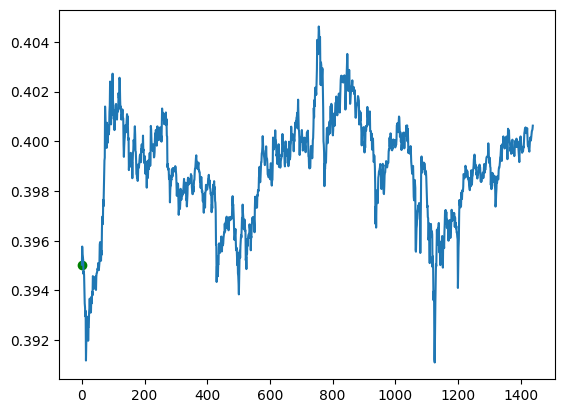

In [96]:
import matplotlib.pyplot as plt

# Get the stock prices
stock_prices = df['Close']

# Create the plot
plt.plot(stock_prices)

# Add green dots for buy positions
buy_positions = df[df['Action'] == 'buy'].index
plt.scatter(buy_positions, stock_prices[buy_positions], color='green', marker='o')

# Add red dots for sell positions
sell_positions = df[df['Action'] == 'close'].index
plt.scatter(sell_positions, stock_prices[sell_positions], color='red', marker='o')

# Show the plot
plt.show()

In [97]:
# get df between our times
# '2021-01-01 00:00:00', '2021-01-02 00:00:00'
timefrom = '2021-01-01 00:00:00'
timeto = '2021-01-02 00:00:00'
timefrom = pd.to_datetime(timefrom)
timeto = pd.to_datetime(timeto)
# convert to unix time milliseconds
timefrom = timefrom.timestamp() * 1000
timeto = timeto.timestamp() * 1000

print(timefrom)

# get the df in our time period
# reload from ccsv
df2 = import_csv('BTCUSDT.csv')
df2 = df2[(df2['Open time'] >= timefrom) & (df2['Open time'] < timeto)]
#rename df2 close column to closeprice
df2 = df2.rename(columns={'Close': 'Closeprice'})


df2 = df2.sort_values(by='Open time').reset_index(drop=True)


# get close and add to df
df['closeprice'] = df2['Closeprice']


# add the open price 
pd.set_option('display.max_rows', 10)  # None means unlimited
pd.set_option('display.max_columns', 10)  # None means unlimited


#print just buy and close
see = df[(df['Action'] == 'buy') | (df['Action'] == 'close')]
print(df)

profit = 0
previous_buy = 0

for index, row in df.iterrows():
    if row['Action'] == 'buy':
        previous_buy = row['closeprice']
    elif row['Action'] == 'close':
        profit += (row['closeprice'] - previous_buy) / previous_buy

print("Total profit from sales:", profit)

1609459200000.0
         Close  5_unit_avg  20_unit_avg  60_unit_avg  10080_unit_avg  \
0     0.395036    0.395927     0.396633     0.397177        0.376959   
1     0.395765    0.396032     0.396657     0.397180        0.376968   
2     0.395454    0.396076     0.396681     0.397182        0.376976   
3     0.395354    0.396255     0.396722     0.397180        0.376985   
4     0.395247    0.396412     0.396836     0.397162        0.376993   
...        ...         ...          ...          ...             ...   
1435  0.400293    0.401187     0.402107     0.401675        0.388836   
1436  0.400408    0.401239     0.402099     0.401688        0.388843   
1437  0.400438    0.401323     0.402102     0.401704        0.388851   
1438  0.400489    0.401414     0.402110     0.401720        0.388858   
1439  0.400627    0.401510     0.402119     0.401738        0.388866   

      Prediction Action  closeprice  
0       0.395232    buy    28961.66  
1       0.395892   hold    29009.91  
2    

In [79]:
#get df again
newnew = import_csv('BTCUSDT.csv')

#get max close price
maxclose = newnew['Close'].max()
minclose = newnew['Close'].min()

#array_3d[:, :, i] = (array_3d[:, :, i] - min_val) / (max_val - min_val)
print(maxclose)
print(minclose)

69000.0
2817.0
